# BERT
___

This model is based on:

```Bibtex
@article{toledo-ronenMultilingualArgumentMining2020,
  title = {Multilingual Argument Mining: {{Datasets}} and Analysis},
  author = {Toledo-Ronen, Orith and Orbach, Matan and Bilu, Yonatan and Spector, Artem and Slonim, Noam},
  date = {2020},
  url = {https://arxiv.org/abs/2010.06432},
}
```

In [23]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import (accuracy_score, classification_report, f1_score,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from transformers import (DistilBertTokenizer,
                          TFDistilBertForSequenceClassification)

from src.dataset import load_dataset
from src.evaluation import confusion_matrix_plot, acc_plot
from config import DATASETS, PROJECT_NAME

import wandb
from wandb.keras import WandbCallback

In [2]:
MODEL_NAME = "distilbert-base-uncased"
TRACKING = False
FALSE_CLASS_BALANCE = 1.0

dataset = DATASETS["dataset_2014"]

### 0. Load data

In [3]:
train_text_split, X_test, train_labels_split, y_test = load_dataset(dataset_path=os.path.join(dataset["base_path"], dataset["data"]), false_class_balance=FALSE_CLASS_BALANCE)

In [4]:
y_train = train_labels_split.apply(lambda x: 0 if x==False else 1)
y_test = y_test.apply(lambda x: 0 if x==False else 1)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(train_text_split, train_labels_split, test_size=.2, random_state=42) # train/test

### 1. Prepare dataset

In [6]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME) # load tokenizer

In [7]:
def tokenize_dataset(dataset):
    """Tokenize a list of strings for the BERT model."""
    encoded = tokenizer(
        dataset,
        padding=True,
        truncation=True,
        return_tensors='np',
    )
    return encoded.data

In [8]:
encodet_train_text = tokenize_dataset(X_train["Sentence"].to_list())
encodet_val_texts = tokenize_dataset(X_val["Sentence"].to_list())
encodet_test_texts = tokenize_dataset(X_test["Sentence"].to_list())

### 2. Create Model

In [9]:
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)  # Load model

2022-01-18 21:40:42.883941: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 21:40:42.890232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 21:40:42.891109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 21:40:42.892037: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
# Set hyperparameter
learning_rate = 5e-5
epochs = 5
batch_size = 16

In [11]:
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_39', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [12]:
model.compile(
    optimizer=optimizer, 
    loss=loss,
    metrics=tf.metrics.SparseCategoricalAccuracy(),
    )

In [13]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


### 3. Train model

In [14]:
if TRACKING:
  report = []
  model.summary(print_fn=lambda x: report.append(x))

  wandb.init(project=PROJECT_NAME,
          config={
              "model": MODEL_NAME,
              "setup": "\n".join(report),
              "dataset": dataset["name"],
              "train_data_size": len(X_train),
              "validation_data_size": len(X_val),
              "test_data_size": len(X_test),
              "batch_size": batch_size,
              "learning_rate": learning_rate,
              "epochs": epochs,
              "false_class_balance": FALSE_CLASS_BALANCE
          })

In [15]:
history = model.fit(
      encodet_train_text,
      np.array(y_train), 
      validation_data=(encodet_val_texts, np.array(y_val)),
      epochs=epochs, 
      batch_size=batch_size,
      # callbacks=[WandbCallback()]
)

#stop = timeit.default_timer()

Epoch 1/5
99/99 [==============================] - 16s 99ms/step - loss: 0.8117 - sparse_categorical_accuracy: 0.7004 - val_loss: 0.4253 - val_sparse_categorical_accuracy: 0.7949
Epoch 2/5
99/99 [==============================] - 9s 90ms/step - loss: 0.6183 - sparse_categorical_accuracy: 0.7555 - val_loss: 0.4528 - val_sparse_categorical_accuracy: 0.8101
Epoch 3/5
99/99 [==============================] - 9s 87ms/step - loss: 0.4601 - sparse_categorical_accuracy: 0.8379 - val_loss: 0.4093 - val_sparse_categorical_accuracy: 0.8152
Epoch 4/5
99/99 [==============================] - 9s 88ms/step - loss: 0.3722 - sparse_categorical_accuracy: 0.8714 - val_loss: 1.5989 - val_sparse_categorical_accuracy: 0.8203
Epoch 5/5
99/99 [==============================] - 9s 88ms/step - loss: 0.3594 - sparse_categorical_accuracy: 0.9335 - val_loss: 1.1262 - val_sparse_categorical_accuracy: 0.8354


### 4. Evaluate results

In [16]:
test_loss, test_accuracy = model.evaluate(encodet_test_texts, np.array(y_test))

16/16 [==============================] - 2s 50ms/step - loss: 1.1006 - sparse_categorical_accuracy: 0.8603


In [17]:
preds = model.predict(encodet_test_texts)

In [18]:
y_pred = np.argmax(preds.logits, axis=1)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.80      0.85       235
           1       0.84      0.91      0.87       259

    accuracy                           0.86       494
   macro avg       0.86      0.86      0.86       494
weighted avg       0.86      0.86      0.86       494



In [20]:
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [21]:
if TRACKING:
    wandb.log({'test_f1': f1})
    wandb.log({'test_recall': recall})
    wandb.log({'test_precision': precision})
    wandb.log({'test_accuracy': accuracy})
    wandb.finish()

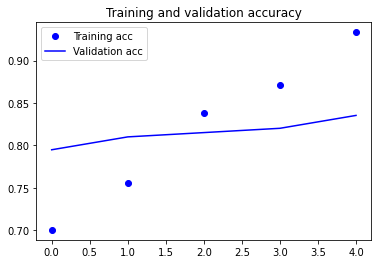

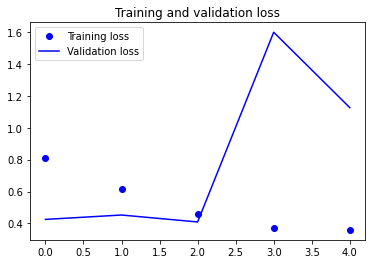

In [24]:
acc_plot(history)

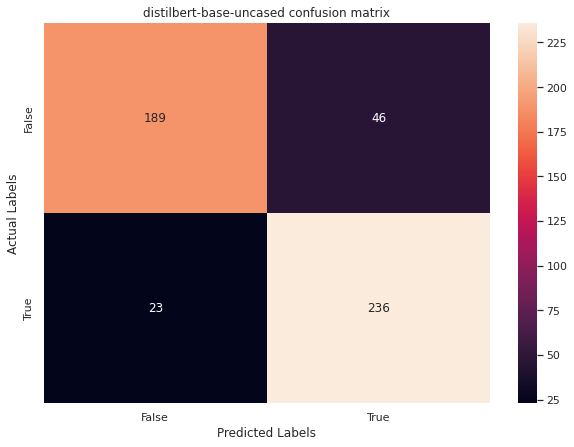

In [25]:
confusion_matrix_plot(y_test, y_pred, label=[False, True], title=MODEL_NAME+" confusion matrix")